# Bob Graham Round predictions 
## Intro
This script attempts to predict a Bob Graham round finishing time based on the race results of other finishers. The membership list of the BGR is imported into the DUV ultramarathon databased to obtain runner ID's. The each race result is then scraped from the DUV site and the results of any of the Bob Graham finishers are then stored. 

The idea is then to input a specific race result that you've completed or specific distance stats to see where you compare to other finishers. Or possibly to use machine learning to predict finish times.

Time improvements can be made by scraping in parallel 

## Load data

In [1]:
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import pandas as pd

### Bob Graham result data

In [2]:
# Load the finishers from the Bob Graham website
CSV_URL = "http://bobgrahamclub.org.uk/api/data_bgr_listing.csv"

bg_results = pd.read_csv(CSV_URL)
bg_results['time seconds'] = pd.to_timedelta(bg_results['time'] + ':00')
bg_results['time seconds'] = bg_results['time seconds'].dt.total_seconds()
print(bg_results.head()) 

        gn        fn gender  age   time        date  weekNum dir  mem  orig  \
0     Alan    Heaton      M   32  22:18  1960-06-26       25   A    1     0   
1  Stanley  Bradshaw      M   48  23:25  1960-07-09       27   C    2     0   
2  Kenneth    Heaton      M   35  22:13  1961-06-24       25   C    3     0   
3     Eric     Beard      M   31  23:35  1963-07-06       27   C    4     0   
4     Joss    Naylor      M   34  23:37  1971-06-26       25   C    5     0   

   ...  record  lr  died  nationality                       club prev  \
0  ...       1   0  2019      British  Clayton-le-Moors Harriers    0   
1  ...       0   0  2010      British  Clayton-le-Moors Harriers    1   
2  ...       1   0  2014      British  Clayton-le-Moors Harriers    0   
3  ...       0   0  1969      British        Leeds Athletic Club    0   
4  ...       0   0     0      British       Kendal Athletic Club    0   

  postcode                                              notes reg_gap  \
0       S8  (

### DUV runner data

In [3]:
# Load DUV bulk search from https://statistik.d-u-v.org/bulk_search.php
DUV_PATH = "./data/DUV_Bulkexport_20240416.xls"

# Results get exported as html rather than xls
def load_html_to_dataframe(file_path):
    try:
        dfs = pd.read_html(file_path, encoding='utf-8')
        return dfs
    except Exception as e:
        print(f"Failed to load the HTML file: {e}")
        return None

duv_runners = load_html_to_dataframe(DUV_PATH)
if duv_runners:
    for i, df in enumerate(duv_runners):
        print(f"Table {i+1}:")
        print(df.head())  # Display the first few rows of each DataFrame

Table 1:
  Unnamed: 0_level_0 DUV Ultra Marathon Statistics                       \
             Counter                       Surname First name Runner ID   
0                  1                        Heaton       Alan   1462093   
1                  2                      Bradshaw    Stanley    Search   
2                  3                        Heaton    Kenneth    Search   
3                  4                         Beard       Eric   1048701   
4                  5                        Naylor       Joss    Search   

                                                                
  Original name Nat.  M/F     YOB Date of birth Cat. internat.  
0           NaN  GBR    M     NaN    00.00.0000            NaN  
1           NaN  NaN  NaN     NaN           NaN            NaN  
2           NaN  NaN  NaN     NaN           NaN            NaN  
3           NaN  GBR    M  1931.0    00.00.0000            NaN  
4           NaN  NaN  NaN     NaN           NaN            NaN  


In [4]:
# DF of runners found by name in DUV bulk search
valid_runners = df[df[('DUV Ultra Marathon Statistics', 'Runner ID')] != 'Search']
valid_runners.columns = valid_runners.columns.droplevel(0)
valid_runners.head()

,Counter,Surname,First name,Runner ID,Original name,Nat.,M/F,YOB,Date of birth,Cat. internat.
0,1,Heaton,Alan,1462093,NaN,GBR,M,NaN,00.00.0000,NaN
3,4,Beard,Eric,1048701,NaN,GBR,M,1931.0,00.00.0000,NaN
6,7,Talbot,Donald,482320,NaN,GBR,M,1932.0,00.00.0000,NaN
12,13,Weir,Dennis,113489,NaN,GBR,M,1938.0,25.03.1938,M85
13,14,Millen,Boyd,1051631,NaN,GBR,M,1936.0,25.01.1936,M85


In [5]:
bg_results.rename(columns={'gn': 'First name', 'fn': 'Surname'}, inplace=True)

# Merging the data on 'First name' and 'Surname'
merged_df = pd.merge(valid_runners, bg_results, on=['First name', 'Surname']).drop_duplicates()

merged_df.head()

,Counter,Surname,First name,Runner ID,Original name,Nat.,M/F,YOB,Date of birth,Cat. internat.,...,record,lr,died,nationality,club,prev,postcode,notes,reg_gap,time seconds
0,1,Heaton,Alan,1462093,NaN,GBR,M,NaN,00.00.0000,NaN,...,1,0,2019,British,Clayton-le-Moors Harriers,0,S8,(R) Brother of Kenneth Heaton (3). * Record time.,25,80280.0
1,4,Beard,Eric,1048701,NaN,GBR,M,1931.0,00.00.0000,NaN,...,0,0,1969,British,Leeds Athletic Club,0,LS6,NaN,26,84900.0
2,13,Weir,Dennis,113489,NaN,GBR,M,1938.0,25.03.1938,M85,...,0,0,0,British,Sale Harriers,0,M23,NaN,30,84840.0
3,14,Millen,Boyd,1051631,NaN,GBR,M,1936.0,25.01.1936,M85,...,1,0,2006,British,Kendal Athletic Club,0,LA9,Record time.,32,74280.0
4,37,Moulding,David,1366214,NaN,GBR,M,1983.0,16.11.1983,M40,...,0,0,0,British,Keswick Athletic Club,0,CA12,NaN,26,85500.0



### Scraping DUV results
Functions for scraping

In [6]:
def fetch_html(url):
    """Fetch the content of a URL with retries and backoff."""
    session = requests.Session()
    # Setup retry strategy
    retries = Retry(
        total=5,  # Total retries
        backoff_factor=1,  # Time between retries, exponential backoff factor
        status_forcelist=[500, 502, 503, 504, 429],  # Retry on these status codes
    )
    # Mount it for both http and https connections
    session.mount('http://', HTTPAdapter(max_retries=retries))
    session.mount('https://', HTTPAdapter(max_retries=retries))

    try:
        response = session.get(url, timeout=10)  # 10 seconds timeout for the request
        if response.ok:
            return BeautifulSoup(response.content, 'html.parser')
        else:
            response.raise_for_status()  # This will raise an error for 4XX client errors
    except requests.RequestException as e:
        print(f"Error fetching the URL {url}: {e}")
        return None

def extract_page_count(soup):
    """Extract the number of pages from the pagination element."""
    pagination = soup.find('div', class_='pagination')
    return int(pagination.find_all('a')[-2].text) if pagination else 1

def extract_event_links(base_url, soup):
    """ Extract event links from the page. """
    links = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        if 'getresultevent.php?event=' in href:
            links.append(base_url + href)
    return links

def extract_event_details(soup):
    """Extract 'Event', 'Date', 'Finishers' and 'Distance' from the HTML content."""
    details = {}
    try:
        info_rows = soup.find_all('tr')  # Find all table rows in the page
        for row in info_rows:
            # Look for rows where the first cell contains the labels we're interested in
            header_cell = row.find('td')
            if header_cell and header_cell.find('b'):  # Check for bold tags which might contain labels
                label = header_cell.get_text(strip=True).rstrip(':')
                value_cell = header_cell.find_next_sibling('td')  # Get the next sibling cell for the value
                if label in ['Date', 'Event', 'Distance', 'Finishers'] and value_cell:
                    details[label] = value_cell.get_text(strip=True)
    except Exception as e:
        print(f"Error extracting event details: {e}")
    return details


def fetch_event_all_data(table_soup, event_details):
    """Extract data and runner IDs from the event table, including event details."""
    data = []
    headers = [th.text.strip() for th in table_soup.find_all('th')]
    # Append the event details headers
    headers.extend(['Runner ID', 'Event', 'Date', 'Distance', 'Finishers'])

    rows = table_soup.find_all('tr')[1:]  # Skip the header row
    for row in rows:
        cols = row.find_all('td')
        row_data = [col.text.strip() for col in cols]
        # Get runner ID
        link = cols[2].find('a', href=True)  # Assuming the third column has the link
        runner_id = link['href'].split('runner=')[-1] if link else 'No ID'
        # Include event details and runner ID
        row_data.extend([runner_id, event_details['Event'], event_details['Date'], event_details['Distance'], event_details['Finishers']])
        data.append(row_data)

    return pd.DataFrame(data, columns=headers)

def fetch_event_data(table_soup, event_details, valid_ids):
    """Extract data and runner IDs from the event table, appending event details, filtered by valid runner IDs."""
    data = []
    headers = [th.text.strip() for th in table_soup.find_all('th')]
    headers.extend(['Runner ID', 'Event', 'Date', 'Distance', 'Finishers','winner_time'])
    rows = table_soup.find_all('tr')[1:]  # Skip header row
    winner_time = None

    # Extract winners time
    for row in rows:
        cols = row.find_all('td')
        rank = int(cols[0].text.strip()) if cols[0].text.strip().isdigit() else None

        if rank == 1:
            winner_time = cols[1].text.strip() 
            break
    
    # Extract specific runners result
    for row in rows:
        cols = row.find_all('td')
        if len(cols) > 2:
            link = cols[2].find('a', href=True)
            if link and 'runner=' in link['href']:
                runner_id = link['href'].split('runner=')[-1]
                # Only add data if runner_id is in the list of valid_ids
                if runner_id in valid_ids:
                    row_data = [col.text.strip() for col in cols]
                    row_data.extend([runner_id, event_details.get('Event', 'N/A'), event_details.get('Date', 'N/A'), event_details.get('Distance', 'N/A'), event_details.get('Finishers', 'N/A'), winner_time or 'N/A'])
                    data.append(row_data)
    
    return pd.DataFrame(data, columns=headers)

def scrape_events(base_url, event_url):
    """Scrape events with additional details."""
    soup = fetch_html(base_url + event_url)
    event_details = extract_event_details(soup)
    table_soup = soup.find('table', {'id': 'Resultlist'})
    if table_soup:
        return fetch_event_data(table_soup, event_details)
    return pd.DataFrame()

def extract_specific_links(soup, base_url, path_starts_with):
    """Extract specific links that start with a given path from the parsed HTML."""
    links = []
    if soup:
        # Find all 'a' tags with an 'href' attribute
        for a in soup.find_all('a', href=True):
            href = a['href']
            # Check if the href starts with the desired path
            if href.startswith(path_starts_with):
                full_link = base_url + href
                links.append(full_link)
    return links

# Function to fetch and process data for a single runner
def process_runner(runner_id):
    athlete_url = f"https://statistik.d-u-v.org/getresultperson.php?runner={runner_id}"
    soup = fetch_html(athlete_url)
    all_data = []

    if soup:
        event_links = extract_specific_links(soup, base_url, "getresultevent.php?event=")

        for event_link in event_links:
            event_page = fetch_html(event_link)
            if event_page:
                event_details = extract_event_details(event_page)
                table_soup = event_page.find('table', {'id': 'Resultlist'})
                if table_soup:
                    event_data = fetch_event_data(table_soup, event_details, valid_ids=runner_id)
                    if not event_data.empty:
                        all_data.append(event_data)

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data


# URL configuration
base_url = "https://statistik.d-u-v.org/"
#event_url = "getresultevent.php?event=102988"

# Perform the scraping
#event_data = scrape_events(base_url, event_url)

# Display or export the data
# print(event_data)


In [7]:
# Retrieve and return dataset for a specific runner without saving to CSV.
def get_runner_data(runner):
    athlete_url = f"https://statistik.d-u-v.org/getresultperson.php?runner={runner}"
    base_url = "https://statistik.d-u-v.org/"

    # Fetch and parse the HTML from the athlete results page
    soup = fetch_html(athlete_url)
    if not soup:
        return pd.DataFrame()  # Return empty DataFrame if failed to fetch HTML

    # Extract specific event links
    event_links = extract_specific_links(soup, base_url, "getresultevent.php?event=")
    all_data = []

    # Process each event link
    for event_link in event_links:
        event_page = fetch_html(event_link)
        if event_page:
            event_details = extract_event_details(event_page)
            table_soup = event_page.find('table', {'id': 'Resultlist'})
            if table_soup:
                event_data = fetch_event_data(table_soup, event_details, valid_ids=runner)
                if not event_data.empty:
                    all_data.append(event_data)

    # Concatenate all data into a single DataFrame
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        return final_df

    return pd.DataFrame()  # Return empty DataFrame if no data was extracted


Scrape results for individual runners

In [ ]:
base_url = "https://statistik.d-u-v.org/"

# List to collect data from all runners
all_runners_data = []

# Loop through each runner in the DataFrame
for runner_id in valid_runners['Runner ID']:
    print(runner_id)
    runner_data = process_runner(runner_id)
    if not runner_data.empty:
        all_runners_data.append(runner_data)

# Concatenate all runner data into a single DataFrame
if all_runners_data:
    final_df = pd.concat(all_runners_data, ignore_index=True)
    final_df.to_csv('./output/all_runners_data.csv', index=False)
    print("Saved all runners' event data to 'all_runners_data.csv'")
else:
    print("No data was extracted for any runner.")



Scrape results for every race  by year

In [ ]:
# Scraping year by year for every race
base_url = "https://statistik.d-u-v.org/"
start_year = 2019
end_year = 2019 

valid_ids = set(valid_runners["Runner ID"])

for year in range(start_year, end_year + 1):
    page_url = f"{base_url}geteventlist.php?year={year}&dist=all&country=all&surface=all&sort=1&page=1"
    first_page = fetch_html(page_url)

    if first_page:
        num_pages = extract_page_count(first_page)
        all_data = []

        for page in range(1, num_pages + 1):
            page_url = f"{base_url}geteventlist.php?year={year}&dist=all&country=all&surface=all&sort=1&page={page}"
            print(page_url)
            page_soup = fetch_html(page_url)
            if page_soup:
                event_links = extract_event_links(base_url, page_soup)
                for event_link in event_links:
                    #print(event_link)
                    event_page = fetch_html(event_link)
                    if event_page:
                        event_details = extract_event_details(event_page)
                        table_soup = event_page.find('table', {'id': 'Resultlist'})
                        if table_soup:
                            event_data = fetch_event_data(table_soup, event_details, valid_ids)
                            if not event_data.empty:
                                all_data.append(event_data)
        
        if all_data:
            final_df = pd.concat(all_data, ignore_index=True)
            final_df.to_csv(f'./output/all_events_data_{year}.csv', index=False)
            print(f"Saved all event data for {year} to 'all_events_data_{year}.csv'.")
        else:
            print(f"No data was extracted for {year}.")

Scrape results for individual runner

In [ ]:
runner = "980130"

# URL for the athlete results page and base URL for forming full URLs
athlete_url = (f"https://statistik.d-u-v.org/getresultperson.php?runner={runner}")
base_url = "https://statistik.d-u-v.org/"

# Fetch and parse the HTML from the athlete results page
soup = fetch_html(athlete_url)

# Extract specific links
specific_links = extract_specific_links(soup, base_url, "getresultevent.php?event=")

# Print the extracted links
print("Extracted Links:")
for link in specific_links:
    print(link)
event_links = extract_specific_links(soup, base_url, "getresultevent.php?event=")
all_data = []

for event_link in event_links:
    event_page = fetch_html(event_link)
    if event_page:
        event_details = extract_event_details(event_page)
        table_soup = event_page.find('table', {'id': 'Resultlist'})
        if table_soup:
            event_data = fetch_event_data(table_soup, event_details, valid_ids = runner)
            if not event_data.empty:
                all_data.append(event_data)

if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df.to_csv(f'./output/runner_{runner}.csv', index=False)
    print(f"Saved all event data for {runner}")
else:
    print(f"No data was extracted for {runner}.")


## Data cleaning

In [9]:
from datetime import timedelta
import re

def runner_name(data):
    data[['Surname', 'First Name']] = data['Surname, first name'].str.split(',', expand=True)
    
    original_name_column = 'Original name\nSurname, first name' 
    if original_name_column in data.columns:
        data['First Name'] = data['First Name'].fillna(data[original_name_column])
        data['Surname'] = data['Surname'].fillna(data[original_name_column])
        data.drop(columns=[original_name_column], inplace=True)

    # Drop the original columns if they are no longer needed
    data.drop(columns=['Surname, first name'], inplace=True)
    return data

def parse_performance(data):
    # Regular expressions to identify time and distance
    time_regex = re.compile(r'(?:(\d+)d )?(\d{1,2}):(\d{2}):(\d{2}) h')
    distance_regex = re.compile(r'(\d+\.?\d*) km')
    
    # Lists to store time and distance results
    times = []
    distances = []
    
    for entry in data['Performance']:
        if 'km' in entry:  # This entry is a distance
            match = distance_regex.search(entry)
            if match:
                distances.append(float(match.group(1)))  # Convert the captured distance to float
                times.append(None)  # No time entry for distances
            else:
                distances.append(None)
                times.append(None)
        else:  # This entry is a time
            match = time_regex.search(entry)
            if match:
                days, hours, minutes, seconds = match.groups(default='0')  # Default missing days to '0'
                # Convert parsed time to total seconds for uniformity and easy handling
                total_seconds = timedelta(days=int(days), hours=int(hours), minutes=int(minutes), seconds=int(seconds)).total_seconds()
                times.append(total_seconds)
                distances.append(None)  # No distance entry for times
            else:
                times.append(None)
                distances.append(None)

    # Create new DataFrame columns for times and distances
    data['Time Seconds Finish'] = times
    data['Distance Finish'] = distances

    return data

def parse_performance_winner(data):
    # Regular expressions to identify time and distance
    time_regex = re.compile(r'(?:(\d+)d )?(\d{1,2}):(\d{2}):(\d{2}) h')
    distance_regex = re.compile(r'(\d+\.?\d*) km')
    
    # Lists to store time and distance results
    times = []
    distances = []
    
    for entry in data['winner_time']:
        if 'km' in entry:  # This entry is a distance
            match = distance_regex.search(entry)
            if match:
                distances.append(float(match.group(1)))  # Convert the captured distance to float
                times.append(None)  # No time entry for distances
            else:
                distances.append(None)
                times.append(None)
        else:  # This entry is a time
            match = time_regex.search(entry)
            if match:
                days, hours, minutes, seconds = match.groups(default='0')  # Default missing days to '0'
                # Convert parsed time to total seconds for uniformity and easy handling
                total_seconds = timedelta(days=int(days), hours=int(hours), minutes=int(minutes), seconds=int(seconds)).total_seconds()
                times.append(total_seconds)
                distances.append(None)  # No distance entry for times
            else:
                times.append(None)
                distances.append(None)

    # Create new DataFrame columns for times and distances
    data['Time Seconds Winner'] = times
    data['Distance Winner'] = distances

    return data

def split_distance_column(df):
    # Define regex patterns to extract the numeric part and the text part
    distance_pattern = re.compile(r'(\d+\.?\d*)\s*(km|mi|h)')  # Matches '50 km', '100 mi', or '24 h'
    race_type_pattern = re.compile(r'(\d+\.?\d*\s*(km|mi|h))\s*(.*)')  # Captures anything after the numeric part
    
    distances = []
    race_types = []

    for entry in df['Distance']:
        # Extract the distance/time
        distance_match = distance_pattern.search(entry)
        if distance_match:
            distances.append(distance_match.group(0))  # Group 0 is the full match, e.g., '50 km' or '24 h'
        else:
            distances.append(None)

        # Extract the race type
        race_type_match = race_type_pattern.search(entry)
        if race_type_match and len(race_type_match.groups()) > 2:
            race_types.append(race_type_match.group(3).strip())  # Group 3 is the race type description
        else:
            race_types.append(None)

    # Assign new columns to the DataFrame
    df['Distance/Time'] = distances
    df['Race Type'] = race_types
    return df

def convert_miles_to_km(entry):
    if pd.isna(entry):
        return None  # Handle missing values
    if isinstance(entry, str):  # Ensure the entry is a string
        # Regular expression to find numbers and units
        match = re.match(r'(\d+\.?\d*)(mi|km)', entry)
        if match:
            distance = float(match.group(1))
            unit = match.group(2)
            if unit == 'mi':
                # Convert miles to kilometers
                return distance * 1.6
            elif unit == 'km':
                # Return kilometers as is
                return distance
    return None  # In case of no match or non-string data

def convert_seconds(seconds):
    td = timedelta(seconds=seconds)
    return str(td)



In [10]:
import os

def load_and_clean_data(directory_path):
    """
    Load all CSV files from the directory, clean them, and combine into a single DataFrame.
    """
    all_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]
    all_data = []  # List to store each DataFrame temporarily
    columns_to_keep = ['Runner ID','First Name','Surname','Nat.','M/F','Cat','YOB','Event','Date','Distance/Time','Distance KM','Race Type','Time Seconds Finish','Distance Finish']

    for file in all_files:
        # Load each CSV file
        df = pd.read_csv(file)

        df = clean_data(df)
        df = split_distance_column(df)
        df = parse_performance(df)
        df['Distance KM'] = df['Distance/Time'].apply(convert_miles_to_km)
        df['Distance KM'] = df['Distance KM'].round(0)
        df = df[columns_to_keep]
        all_data.append(df)

    # Concatenate all data into a single DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

# Specify the directory path where CSV files are stored
#directory_path = './data/duv_results/'  # Adjust the path to your needs

# Load, clean, and combine all CSV data
#cleaned_data = load_and_clean_data(directory_path)

#cleaned_data.head()

def clean_data(df):
    columns_to_keep = ['Runner ID','First Name','Surname','Nat.','M/F','Cat','YOB','Event','Date','Finishers','Rank','Finish Percentage','Winner Time Percentage','Distance/Time','Distance KM','Race Type','Time Seconds Finish','Distance Finish','Average Speed', 'Avg.Speed km/h']

    df = runner_name(df)
    df = split_distance_column(df)
    df = parse_performance(df)
    df = parse_performance_winner(df)
    #df['Runner ID'] = df['Runner ID'].astype(int)
    df['Distance KM'] = df['Distance/Time'].apply(convert_miles_to_km)
    df['Distance KM'] = df['Distance KM'].round(0)
    df['Total Finishers'] = df['Finishers'].str.extract(r'^(\d+)')
    df['Total Finishers'] = df['Total Finishers'].astype(int)
    df['Finish Percentage'] = df['Rank']/df['Total Finishers']
    df['Winner Time Percentage'] = df['Time Seconds Winner']/df['Time Seconds Finish']
    df['Distance KM'] = df['Distance KM'].replace(0, pd.NA)  # Replace 0s with NaN to avoid division errors

    # Calculate average speed (seconds per kilometer)
    df['Average Speed'] = df['Time Seconds Finish'] / df['Distance KM']

    df = df[columns_to_keep]
    return df

In [11]:
df = pd.read_csv("./output/all_runners_data.csv")
df = df.dropna(subset=['winner_time'])
df = clean_data(df)

df.head()

,Runner ID,First Name,Surname,Nat.,M/F,Cat,YOB,Event,Date,Finishers,Rank,Finish Percentage,Winner Time Percentage,Distance/Time,Distance KM,Race Type,Time Seconds Finish,Distance Finish,Average Speed,Avg.Speed km/h
0,1462093,Alan,Heaton,GBR,M,NaN,NaN,Old County Tops Fell Race (GBR),21.05.1988,"42 (38 M, 4 F)",27,0.642857,0.777403,37mi,59.0,trail race,35580.0,NaN,603.050847,6.025
1,1048701,Eric,Beard,GBR,M,M23,1931.0,4th Balfe Cup 50 Mile Track Race (GBR),15.10.1966,"7 (7 M, 0 F)",7,1.000000,0.834408,50mi,80.0,track,22483.0,NaN,281.037500,12.884
2,1048701,Eric,Beard,GBR,M,M23,1931.0,4th 40 mile road race - Woodford to Southend (...,10.09.1966,"23 (23 M, 0 F)",17,0.739130,0.778273,37mi,59.0,road race,17941.0,NaN,304.084746,11.948
3,1048701,Eric,Beard,GBR,M,M23,1931.0,15th London to Brighton Road Race (GBR),25.09.1965,"36 (36 M, 0 F)",12,0.333333,0.888091,84.5km,84.0,road race,22983.0,NaN,273.607143,13.236
4,482320,Donald,Talbot,GBR,M,M70,1932.0,Haworth Hobble 32 Miles (GBR),14.03.2004,"212 (177 M, 35 F)",198,0.933962,0.424424,32mi,51.0,trail race,33377.0,NaN,654.450980,5.555


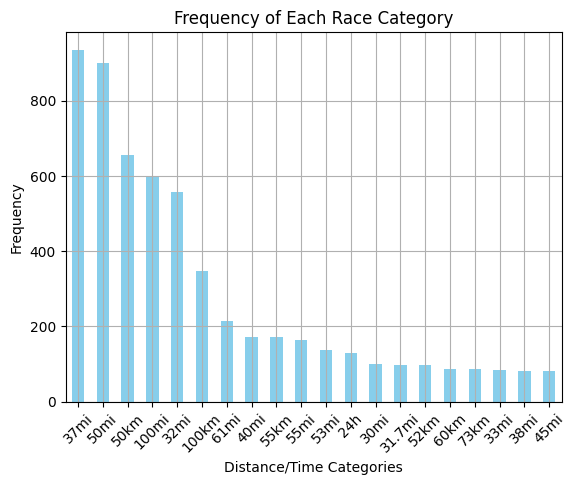

In [12]:
import matplotlib.pyplot as plt

value_counts = df['Distance/Time'].value_counts()
value_counts = value_counts.head(20)

# Plotting the bar chart
value_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Race Category')
plt.xlabel('Distance/Time Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  
plt.grid(True)

# Show the plot
plt.show()

## Predictions
Process data and split training & test sets

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [14]:
# List the top n race distances for one-hot encoding
top_distances = df['Distance KM'].value_counts().nlargest(10).index.tolist()

In [15]:
df = df.dropna(subset=['Distance KM'])

# Map all other distances to 'Other'
df['Distance KM'] = df['Distance KM'].apply(lambda x: x if x in top_distances else 'Other')

# One-hot encode the race distances
df_encoded = pd.get_dummies(df, columns=['Distance KM'])

label_encoder = LabelEncoder()

# Apply label encoder on 'gender'
df_encoded['gender_encoded'] = label_encoder.fit_transform(df_encoded['M/F'])

df_encoded.head()

,Runner ID,First Name,Surname,Nat.,M/F,Cat,YOB,Event,Date,Finishers,...,Distance KM_55.0,Distance KM_59.0,Distance KM_64.0,Distance KM_80.0,Distance KM_85.0,Distance KM_98.0,Distance KM_100.0,Distance KM_160.0,Distance KM_Other,gender_encoded
0,1462093,Alan,Heaton,GBR,M,NaN,NaN,Old County Tops Fell Race (GBR),21.05.1988,"42 (38 M, 4 F)",...,0,1,0,0,0,0,0,0,0,1
1,1048701,Eric,Beard,GBR,M,M23,1931.0,4th Balfe Cup 50 Mile Track Race (GBR),15.10.1966,"7 (7 M, 0 F)",...,0,0,0,1,0,0,0,0,0,1
2,1048701,Eric,Beard,GBR,M,M23,1931.0,4th 40 mile road race - Woodford to Southend (...,10.09.1966,"23 (23 M, 0 F)",...,0,1,0,0,0,0,0,0,0,1
3,1048701,Eric,Beard,GBR,M,M23,1931.0,15th London to Brighton Road Race (GBR),25.09.1965,"36 (36 M, 0 F)",...,0,0,0,0,0,0,0,0,1,1
4,482320,Donald,Talbot,GBR,M,M70,1932.0,Haworth Hobble 32 Miles (GBR),14.03.2004,"212 (177 M, 35 F)",...,0,0,0,0,0,0,0,0,0,1


In [16]:
df_encoded.columns

Index(['Runner ID', 'First Name', 'Surname', 'Nat.', 'M/F', 'Cat', 'YOB',
       'Event', 'Date', 'Finishers', 'Rank', 'Finish Percentage',
       'Winner Time Percentage', 'Distance/Time', 'Race Type',
       'Time Seconds Finish', 'Distance Finish', 'Average Speed',
       'Avg.Speed km/h', 'Distance KM_50.0', 'Distance KM_51.0',
       'Distance KM_55.0', 'Distance KM_59.0', 'Distance KM_64.0',
       'Distance KM_80.0', 'Distance KM_85.0', 'Distance KM_98.0',
       'Distance KM_100.0', 'Distance KM_160.0', 'Distance KM_Other',
       'gender_encoded'],
      dtype='object')

In [17]:
# Aggregate data to create features
features = df_encoded.groupby('Runner ID').agg(
    average_time=('Time Seconds Finish', 'mean'),
    min_time=('Time Seconds Finish', 'min'),
    max_time=('Time Seconds Finish', 'max'),
    count_races=('Time Seconds Finish', 'count'),
    avg_percentile=('Finish Percentage', 'mean'),
    avg_speed_diff=('Winner Time Percentage', 'mean'),
    max_speed_diff=('Winner Time Percentage', 'max'),
    min_speed_diff=('Winner Time Percentage', 'min'),
    avg_speed=('Average Speed', 'mean'),
    max_speed=('Average Speed', 'max'),
    min_speed=('Average Speed', 'min'),
    gender=('gender_encoded', 'mean'),
    **{f"count_{dist}": (f"{dist}", 'sum') for dist in df_encoded.columns if 'Distance KM_' in dist}
).reset_index()

features.head()

,Runner ID,average_time,min_time,max_time,count_races,avg_percentile,avg_speed_diff,max_speed_diff,min_speed_diff,avg_speed,...,count_Distance KM_51.0,count_Distance KM_55.0,count_Distance KM_59.0,count_Distance KM_64.0,count_Distance KM_80.0,count_Distance KM_85.0,count_Distance KM_98.0,count_Distance KM_100.0,count_Distance KM_160.0,count_Distance KM_Other
0,1,43464.75,42674.0,44370.0,4,0.937333,0.489408,0.510428,0.472256,553.789583,...,0,0,0,0,1,0,0,0,0,3
1,2,33260.50,29881.0,36640.0,2,0.369177,0.660493,0.723169,0.597817,426.416667,...,0,0,0,0,0,0,0,0,0,2
2,4,42880.00,42880.0,42880.0,1,0.337574,0.548134,0.548134,0.548134,428.800000,...,0,0,0,0,0,0,0,1,0,0
3,5,188325.40,15395.0,231558.0,5,0.806168,0.543739,0.735434,0.495815,640.475000,...,0,0,0,0,0,0,0,0,0,4
4,7,17189.00,14275.0,25518.0,5,0.177858,0.743012,0.775649,0.693382,311.620329,...,0,0,0,0,0,0,0,0,0,1


In [18]:
merged_df['Runner ID'] = merged_df['Runner ID'].astype(int)

columns_to_keep = ['Runner ID', 'time seconds']
data_cleaned = merged_df[columns_to_keep]


df_merged = pd.merge(data_cleaned, features, on='Runner ID', suffixes=('_bgr', '_results'))
df_merged.head()

,Runner ID,time seconds,average_time,min_time,max_time,count_races,avg_percentile,avg_speed_diff,max_speed_diff,min_speed_diff,...,count_Distance KM_51.0,count_Distance KM_55.0,count_Distance KM_59.0,count_Distance KM_64.0,count_Distance KM_80.0,count_Distance KM_85.0,count_Distance KM_98.0,count_Distance KM_100.0,count_Distance KM_160.0,count_Distance KM_Other
0,1462093,80280.0,35580.000000,35580.0,35580.0,1,0.642857,0.777403,0.777403,0.777403,...,0,0,1,0,0,0,0,0,0,0
1,1048701,84900.0,21135.666667,17941.0,22983.0,3,0.690821,0.833591,0.888091,0.778273,...,0,0,1,0,1,0,0,0,0,1
2,113489,84840.0,18530.166667,10987.0,29524.0,18,0.346615,0.866702,1.000000,0.728397,...,0,0,0,9,1,0,0,3,0,3
3,1051631,74280.0,68502.333333,37559.0,84343.0,3,0.729101,0.865375,0.914954,0.807930,...,0,0,0,0,1,0,0,0,2,0
4,1366214,85500.0,46601.428571,19644.0,103714.0,7,0.420246,0.688763,0.792558,0.601395,...,1,0,0,0,0,0,0,1,1,3


In [19]:
# Prepare data for training
X = df_merged.drop('time seconds', axis=1) 
y = df_merged['time seconds']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [20]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 5057.288934715503


In [21]:
# Cross-validation for model tuning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Setup the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize a Random Forest classifier
rf = RandomForestClassifier()

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit grid search
best_model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [22]:
# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

Best parameters found:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation score: 0.040


In [57]:
model_rf = RandomForestRegressor(max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42)
#model = RandomForestRegressor(grid_search.best_params_, random_state=42)
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = model_rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 4983.969209176085


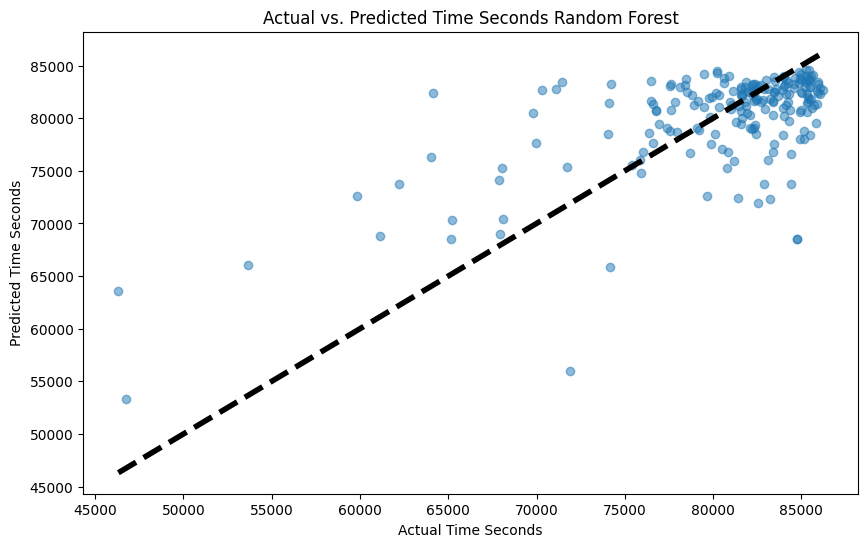

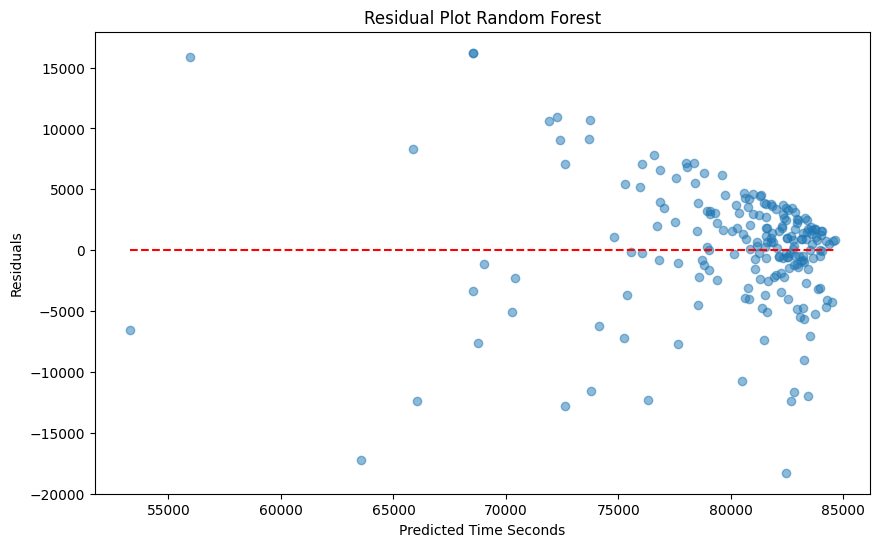

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual Time Seconds')
plt.ylabel('Predicted Time Seconds')
plt.title('Actual vs. Predicted Time Seconds Random Forest')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')  # Line at 0 for no residual
plt.xlabel('Predicted Time Seconds')
plt.ylabel('Residuals')
plt.title('Residual Plot Random Forest')
plt.show()

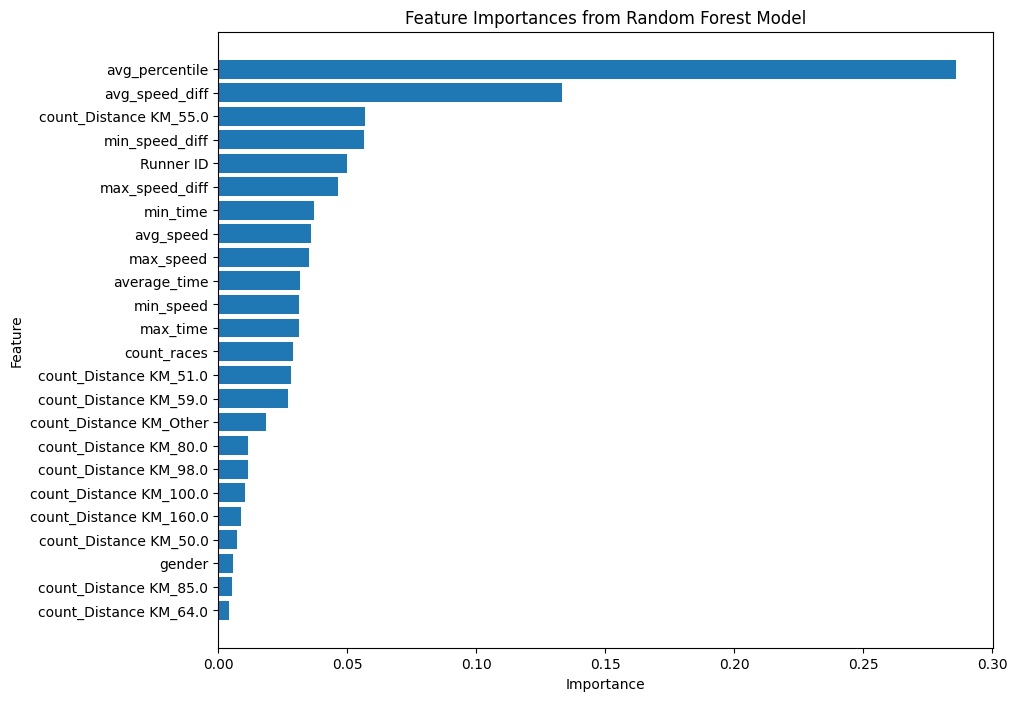

In [40]:
feature_importances = model.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame to show more important features on top
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

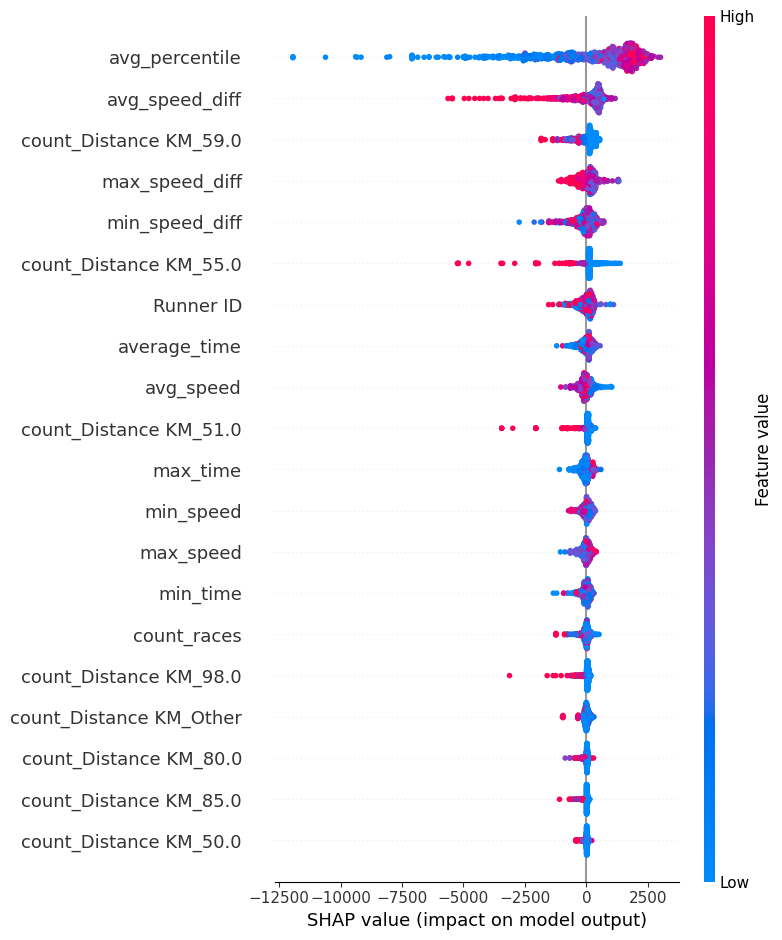

In [41]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Plot the summary
shap.summary_plot(shap_values, X_train)

### XGBoost

[0]	train-rmse:5621.65645+75.16355	test-rmse:5723.12229+296.51200
[1]	train-rmse:5354.69954+74.30221	test-rmse:5577.76107+245.33552
[2]	train-rmse:5123.39536+69.34605	test-rmse:5464.03588+210.15131
[3]	train-rmse:4895.34687+68.70384	test-rmse:5367.26753+180.66097
[4]	train-rmse:4687.87013+68.88307	test-rmse:5277.09890+145.21521
[5]	train-rmse:4507.87507+56.74080	test-rmse:5198.42246+130.27146
[6]	train-rmse:4334.14912+52.39634	test-rmse:5146.40963+118.60277
[7]	train-rmse:4170.26290+53.24546	test-rmse:5090.45134+120.70402
[8]	train-rmse:4033.53480+55.15843	test-rmse:5064.15521+131.33023
[9]	train-rmse:3896.35079+53.11838	test-rmse:5035.37085+145.93088
[10]	train-rmse:3769.66200+42.27103	test-rmse:5010.48445+162.33306
[11]	train-rmse:3661.30721+38.94986	test-rmse:4996.04969+179.04208
[12]	train-rmse:3553.46573+36.61414	test-rmse:4984.89003+198.48806
[13]	train-rmse:3468.60555+40.01377	test-rmse:4985.99970+209.23375
[14]	train-rmse:3383.46544+49.86113	test-rmse:4981.27039+219.98136
[15]	

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

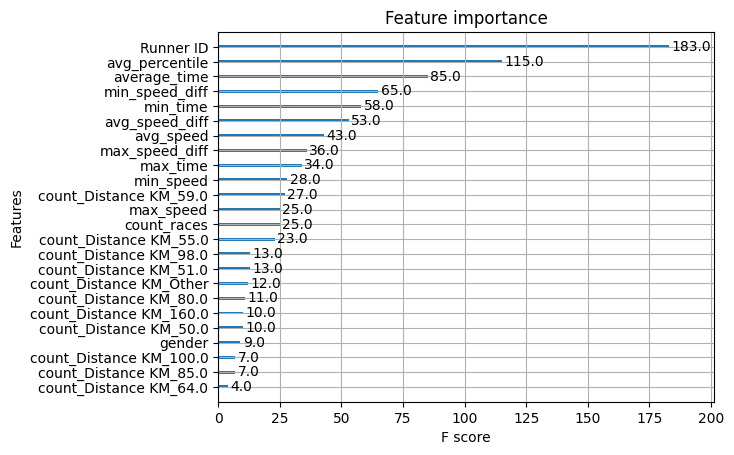

In [43]:
import xgboost as xgb

# Convert training data to DMatrix, an optimized data structure for XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train)

# Set up initial parameters
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'rmse'
}

# Perform cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=train_dmatrix,
    num_boost_round=100,
    nfold=5,  # Number of CV folds
    early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
    verbose_eval=True,
    seed=42
)

# Get the optimal number of boosting rounds
optimal_boost_rounds = len(cv_results)

# Train the final model using the optimal number of boosting rounds
model_xgb = xgb.XGBRegressor(
    n_estimators=optimal_boost_rounds,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f"RMSE: {rmse}")

# Optionally, you can plot feature importance
xgb.plot_importance(model_xgb)

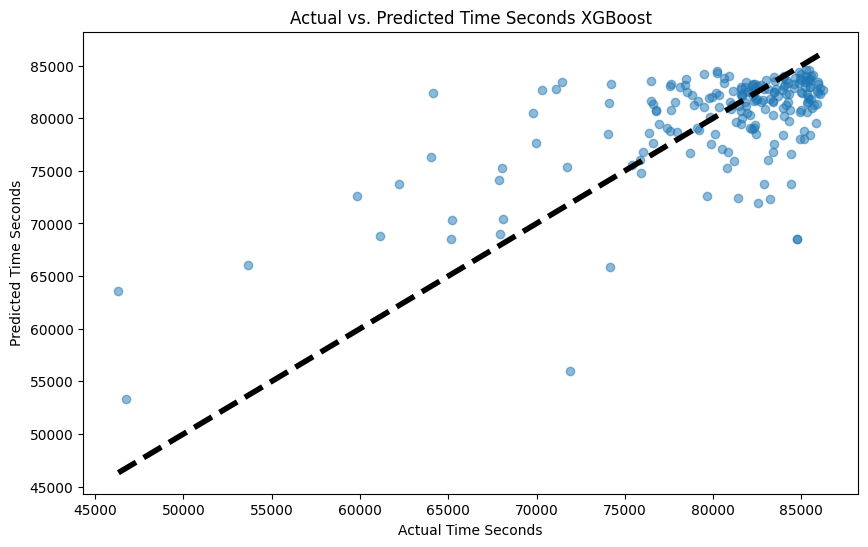

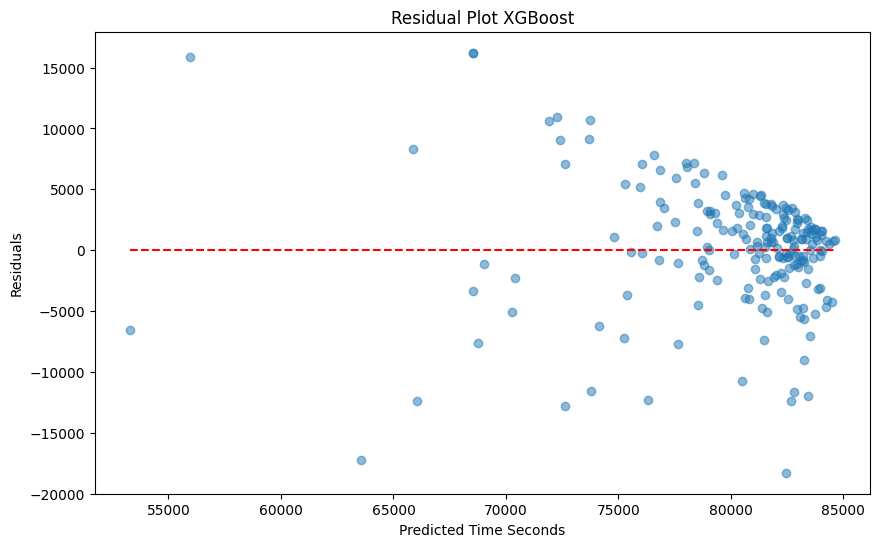

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual Time Seconds')
plt.ylabel('Predicted Time Seconds')
plt.title('Actual vs. Predicted Time Seconds XGBoost')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')  # Line at 0 for no residual
plt.xlabel('Predicted Time Seconds')
plt.ylabel('Residuals')
plt.title('Residual Plot XGBoost')
plt.show()

### Polynomial regression

In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Polynomial transformation
poly = PolynomialFeatures(degree=1) # 1 degree most accurate 
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Make predictions
y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate the model
rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)
print(f"Polynomial Regression RMSE: {rmse_poly}")


Polynomial Regression RMSE: 5706.623647776045


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


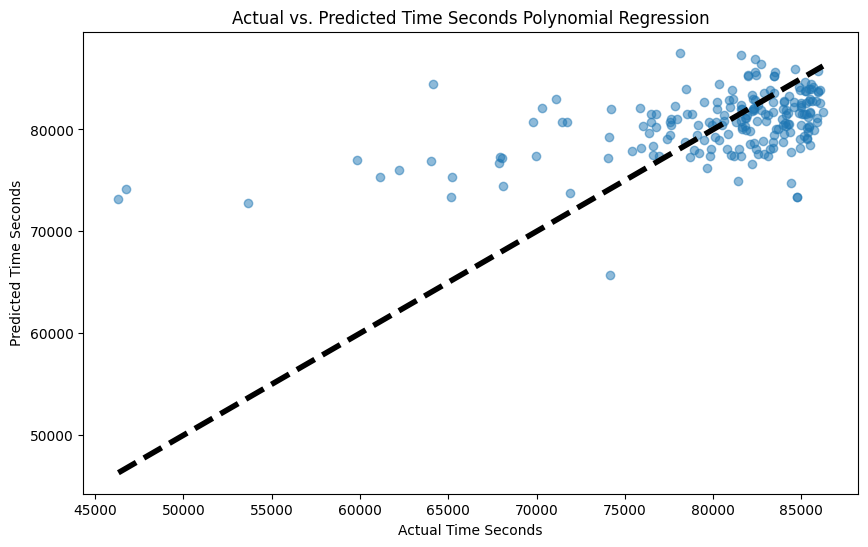

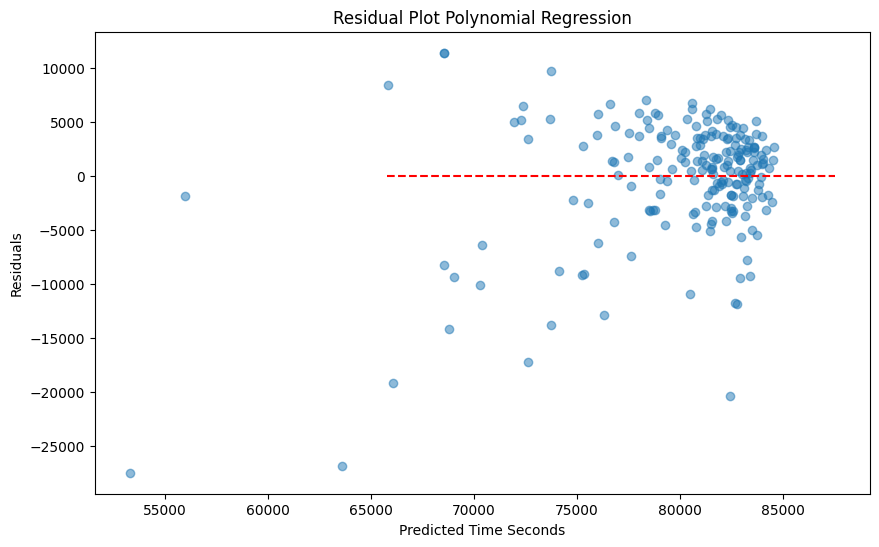

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual Time Seconds')
plt.ylabel('Predicted Time Seconds')
plt.title('Actual vs. Predicted Time Seconds Polynomial Regression')
plt.show()

# Residual plot
residuals = y_test - y_pred_poly
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_poly.min(), xmax=y_pred_poly.max(), colors='red', linestyles='--')  # Line at 0 for no residual
plt.xlabel('Predicted Time Seconds')
plt.ylabel('Residuals')
plt.title('Residual Plot Polynomial Regression')
plt.show()

### Support Vector Regression

In [48]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 1.0]
}

# Initialize the SVR model
svr = SVR()

# Initialize GridSearchCV with 5-fold cross-validation
grid_search_svr = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model
grid_search_svr.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_svr = grid_search_svr.best_params_
print("Best parameters for SVR:", best_params_svr)

# Make predictions using the best model
model_svr = grid_search_svr.best_estimator_
y_pred_svr = model_svr.predict(X_test_scaled)

# Make predictions
y_pred_svr = model_svr.predict(X_test_scaled)

# Evaluate the model
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
print(f"SVR RMSE: {rmse_svr}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for SVR: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVR RMSE: 6167.157857764566


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


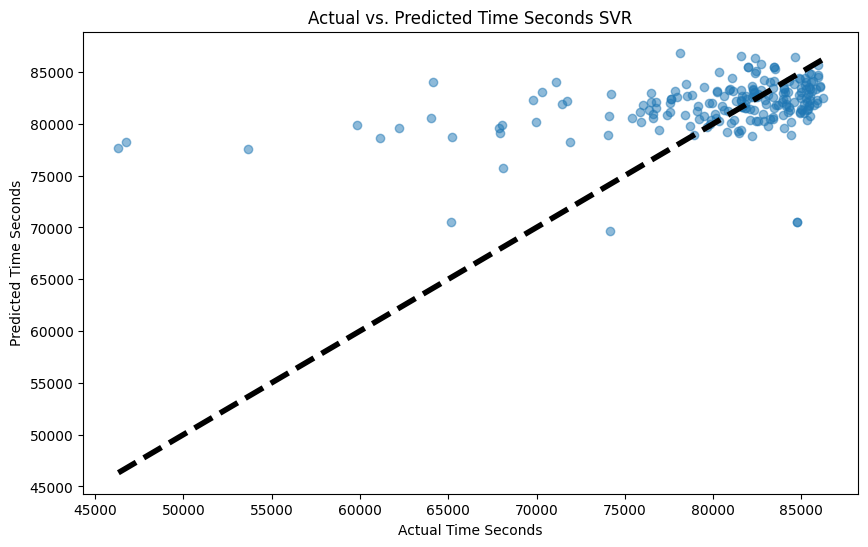

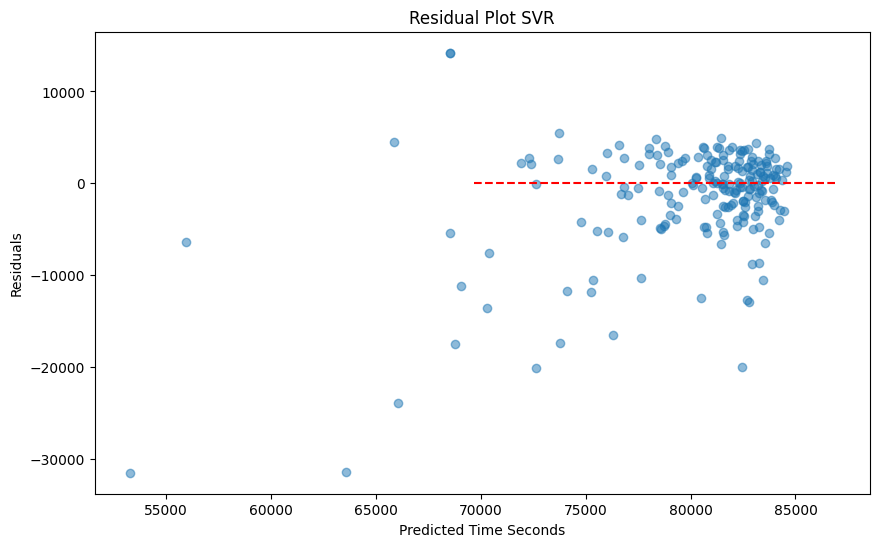

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual Time Seconds')
plt.ylabel('Predicted Time Seconds')
plt.title('Actual vs. Predicted Time Seconds SVR')
plt.show()

# Residual plot
residuals = y_test - y_pred_svr
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_svr.min(), xmax=y_pred_svr.max(), colors='red', linestyles='--')  # Line at 0 for no residual
plt.xlabel('Predicted Time Seconds')
plt.ylabel('Residuals')
plt.title('Residual Plot SVR')
plt.show()

### Neural Net

In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model_nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model_nn.compile(optimizer='rmsprop', loss='mean_squared_error')

# Train the model
model_nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions
y_pred_nn = model_nn.predict(X_test_scaled).flatten()

# Evaluate the model
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
print(f"Neural Network RMSE: {rmse_nn}")


Epoch 1/50


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6527603200.0000 - val_loss: 6546024448.0000
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6473192448.0000 - val_loss: 6540617728.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6509387264.0000 - val_loss: 6529724928.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6480340992.0000 - val_loss: 6510153728.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 6452773376.0000 - val_loss: 6479706624.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6447672320.0000 - val_loss: 6434893824.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6360376832.0000 - val_loss: 6373060608.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6304608768.0000 - val_loss: 6289797632.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6223568896.0000 - val_loss: 6181967360.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6120803840.0000 - val_loss: 6046

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


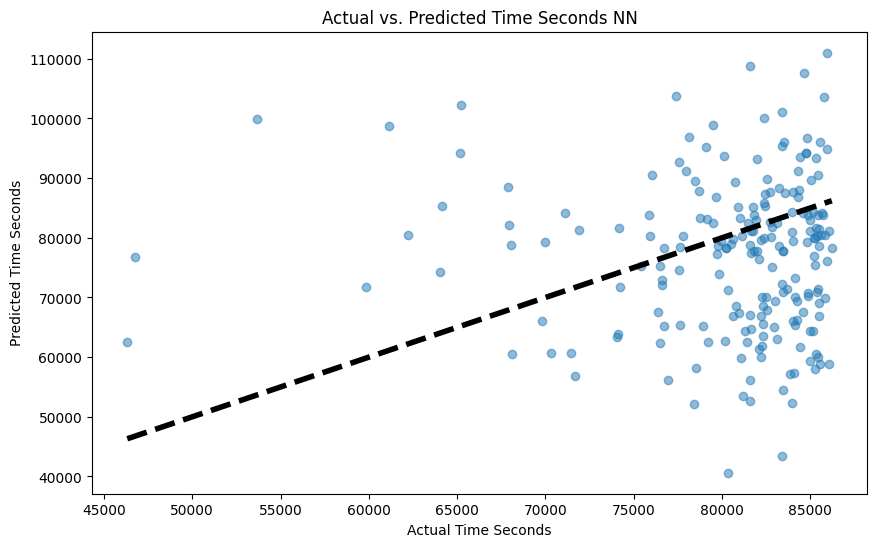

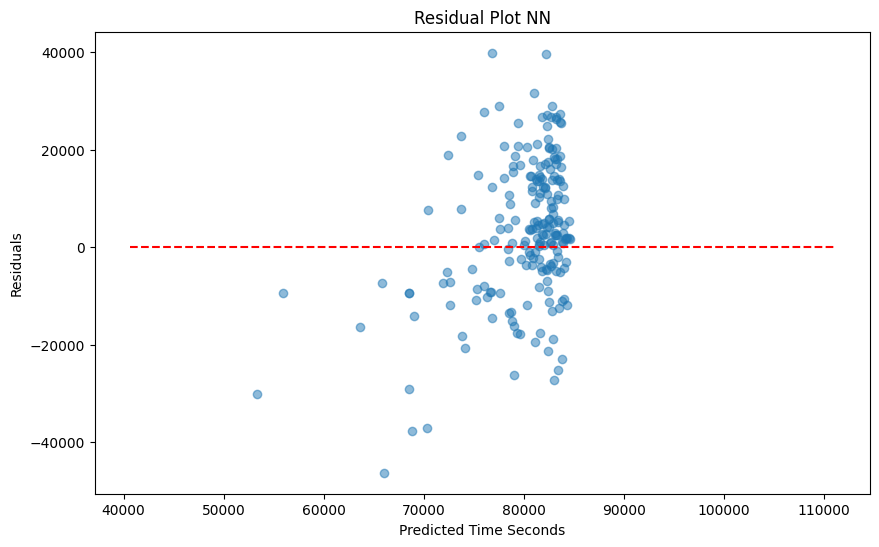

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual Time Seconds')
plt.ylabel('Predicted Time Seconds')
plt.title('Actual vs. Predicted Time Seconds NN')
plt.show()

# Residual plot
residuals = y_test - y_pred_nn
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_nn.min(), xmax=y_pred_nn.max(), colors='red', linestyles='--')  # Line at 0 for no residual
plt.xlabel('Predicted Time Seconds')
plt.ylabel('Residuals')
plt.title('Residual Plot NN')
plt.show()

## Predictions
Aiming to predict the time for runner 980130

In [42]:
runner = "980130"
runner_data = get_runner_data(runner)
runner_data['Runner ID'] = runner_data['Runner ID'].astype(int)
runner_data['Rank'] = runner_data['Rank'].astype(int)
runner_data = clean_data(runner_data)
print(runner_data)

    Runner ID        First Name           Surname Nat. M/F  Cat   YOB  \
0      980130  Duckett, Matthew  Duckett, Matthew  GBR   M  M23  1991   
1      980130  Duckett, Matthew  Duckett, Matthew  GBR   M  M23  1991   
2      980130  Duckett, Matthew  Duckett, Matthew  GBR   M  M23  1991   
3      980130  Duckett, Matthew  Duckett, Matthew  GBR   M  M23  1991   
4      980130           Matthew           Duckett  GBR   M  M23  1991   
5      980130           Matthew           Duckett  GBR   M  M23  1991   
6      980130           Matthew           Duckett  GBR   M  M23  1991   
7      980130           Matthew           Duckett  GBR   M  M23  1991   
8      980130           Matthew           Duckett  GBR   M  M23  1991   
9      980130           Matthew           Duckett  GBR   M  M23  1991   
10     980130           Matthew           Duckett  GBR   M  M23  1991   
11     980130           Matthew           Duckett  GBR   M  M23  1991   
12     980130  Duckett, Matthew  Duckett, Matthew  

In [52]:
runner_data = runner_data.dropna(subset=['Distance KM'])

# Map all other distances to 'Other'
runner_data['Distance KM'] = runner_data['Distance KM'].apply(lambda x: x if x in top_distances else 'Other')

# One-hot encode the race distances
runner_encoded = pd.get_dummies(runner_data, columns=['Distance KM'])

label_encoder = LabelEncoder()

# Apply label encoder on 'gender'
runner_encoded['gender_encoded'] = label_encoder.fit_transform(runner_encoded['M/F'])

runner_encoded.head()

,Runner ID,First Name,Surname,Nat.,M/F,Cat,YOB,Event,Date,Finishers,...,Time Seconds Finish,Distance Finish,Average Speed,Avg.Speed km/h,Distance KM_50.0,Distance KM_80.0,Distance KM_100.0,Distance KM_160.0,Distance KM_Other,gender_encoded
0,980130,"Duckett, Matthew","Duckett, Matthew",GBR,M,M23,1991,6th Hurtwood 50k Endurance Trail Run (GBR),03.12.2023,"415 (312 M, 103 F)",...,18162.0,None,363.240000,9.911,1,0,0,0,0,0
1,980130,"Duckett, Matthew","Duckett, Matthew",GBR,M,M23,1991,Ultra Tour Monte Rosa - Ultra 170 (SUI),06.09.2023,"95 (87 M, 8 F)",...,152608.0,None,897.694118,4.010,0,0,0,0,1,0
2,980130,"Duckett, Matthew","Duckett, Matthew",GBR,M,M23,1991,5th Ultra-Trail Snowdonia - 100mi (GBR),12.-14.05.2023,"95 (87 M, 8 F)",...,122818.0,None,748.890244,4.807,0,0,0,0,1,0
3,980130,"Duckett, Matthew","Duckett, Matthew",GBR,M,M23,1991,6th Wendover Woods 50 (GBR),12.11.2022,"198 (164 M, 34 F)",...,32511.0,None,406.387500,8.910,0,1,0,0,0,0
4,980130,Matthew,Duckett,GBR,M,M23,1991,Wayfarers 100k (GBR),09.07.2022,"20 (17 M, 3 F)",...,36223.0,None,362.230000,9.938,0,0,1,0,0,0


In [53]:
def prepare_data_for_prediction(new_data, expected_features):
    # Add missing columns with default value of zero
    for feature in expected_features:
        if feature not in new_data.columns:
            new_data[feature] = 0
    
    # Reorder columns to match the model's expectations
    new_data = new_data.reindex(columns=expected_features, fill_value=0)
    
    return new_data

# Example usage
model_features = list(df_encoded.columns)  # Where model_features are your model's features
prepared_data = prepare_data_for_prediction(runner_encoded, model_features)



In [54]:
prepared_data.head()

,Runner ID,First Name,Surname,Nat.,M/F,Cat,YOB,Event,Date,Finishers,...,Distance KM_55.0,Distance KM_59.0,Distance KM_64.0,Distance KM_80.0,Distance KM_85.0,Distance KM_98.0,Distance KM_100.0,Distance KM_160.0,Distance KM_Other,gender_encoded
0,980130,"Duckett, Matthew","Duckett, Matthew",GBR,M,M23,1991,6th Hurtwood 50k Endurance Trail Run (GBR),03.12.2023,"415 (312 M, 103 F)",...,0,0,0,0,0,0,0,0,0,0
1,980130,"Duckett, Matthew","Duckett, Matthew",GBR,M,M23,1991,Ultra Tour Monte Rosa - Ultra 170 (SUI),06.09.2023,"95 (87 M, 8 F)",...,0,0,0,0,0,0,0,0,1,0
2,980130,"Duckett, Matthew","Duckett, Matthew",GBR,M,M23,1991,5th Ultra-Trail Snowdonia - 100mi (GBR),12.-14.05.2023,"95 (87 M, 8 F)",...,0,0,0,0,0,0,0,0,1,0
3,980130,"Duckett, Matthew","Duckett, Matthew",GBR,M,M23,1991,6th Wendover Woods 50 (GBR),12.11.2022,"198 (164 M, 34 F)",...,0,0,0,1,0,0,0,0,0,0
4,980130,Matthew,Duckett,GBR,M,M23,1991,Wayfarers 100k (GBR),09.07.2022,"20 (17 M, 3 F)",...,0,0,0,0,0,0,1,0,0,0


In [55]:
# Aggregate data to create features
features_runner = prepared_data.groupby('Runner ID').agg(
    average_time=('Time Seconds Finish', 'mean'),
    min_time=('Time Seconds Finish', 'min'),
    max_time=('Time Seconds Finish', 'max'),
    count_races=('Time Seconds Finish', 'count'),
    avg_percentile=('Finish Percentage', 'mean'),
    avg_speed_diff=('Winner Time Percentage', 'mean'),
    max_speed_diff=('Winner Time Percentage', 'max'),
    min_speed_diff=('Winner Time Percentage', 'min'),
    avg_speed=('Average Speed', 'mean'),
    max_speed=('Average Speed', 'max'),
    min_speed=('Average Speed', 'min'),
    gender=('gender_encoded', 'mean'),
    **{f"count_{dist}": (f"{dist}", 'sum') for dist in prepared_data.columns if 'Distance KM_' in dist}
).reset_index()

print(features_runner)

   Runner ID  average_time  min_time  max_time  count_races  avg_percentile  \
0     980130  56031.944444   14282.0  152608.0           18        0.115439   

   avg_speed_diff  max_speed_diff  min_speed_diff  avg_speed  ...  \
0        0.811986             1.0        0.649595  473.41349  ...   

   count_Distance KM_51.0  count_Distance KM_55.0  count_Distance KM_59.0  \
0                       0                       0                       0   

   count_Distance KM_64.0  count_Distance KM_80.0  count_Distance KM_85.0  \
0                       0                       5                       0   

   count_Distance KM_98.0  count_Distance KM_100.0  count_Distance KM_160.0  \
0                       0                        1                        2   

   count_Distance KM_Other  
0                        5  

[1 rows x 24 columns]


In [59]:
predictions_rf = model_rf.predict(features_runner)
predicted_time = convert_seconds(predictions_rf[0])

print(f"Predicted Time Seconds for the runner under RF model: {predicted_time}")


Predicted Time Seconds for the runner under RF model: 21:33:07.417465


In [72]:
predixt_x_scaler = scaler.transform(features_runner)
predict_x_poly = poly.transform(features_runner)

predictions_xgb = model_xgb.predict(features_runner)
predictions_svr = model_svr.predict(predixt_x_scaler)
predictions_poly = model_poly.predict(predict_x_poly)
predictions_nn = model_nn.predict(predixt_x_scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [78]:
predictions_data = {
    'model': ['Random Forest'] * len(predictions_rf) +
             ['XGBoost'] * len(predictions_xgb) + 
             ['SVR'] * len(predictions_svr) + 
             ['Polynomial Regression'] * len(predictions_poly) + 
             ['Neural Network'] * len(predictions_nn),
    'prediction': list(predictions_rf) + 
                  list(predictions_xgb) + 
                  list(predictions_svr) + 
                  list(predictions_poly) + 
                  list(predictions_nn)
}

# Create the DataFrame
predictions_data = pd.DataFrame(predictions_data)

predictions_data['prediction'] = predictions_data['prediction'].astype(float)
predictions_data['formatted_prediction'] = predictions_data['prediction'].apply(convert_seconds)

print(predictions_data)

                   model    prediction formatted_prediction
0          Random Forest  77587.417465      21:33:07.417465
1                XGBoost  75062.000000             20:51:02
2                    SVR  82598.356126      22:56:38.356126
3  Polynomial Regression  81526.156993      22:38:46.156993
4         Neural Network  52463.695312      14:34:23.695312
